In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit import *
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from operator import attrgetter, itemgetter
import heapq
from scipy.spatial.distance import cityblock

In [2]:
# Target & reward ------------------------------------------------------------------------

In [3]:
class Target:
    def __init__(self,name,x,y): # no indetermination in the target's position
        self.name = name
        self.x = x
        self.y = y

In [4]:
T = Target("T", 0.875, 0.125) # deep in the ocean

In [5]:
# the closer the target, the less the distance, the higher the reward
def reward(T, betax, betay):
    return 1 - ((T.x - betax)**2 + (T.y - betay)**2)**0.5

In [6]:
# Obstacles ----------------------------------------------------------------------------

In [7]:
class Obstacle:
    def __init__(self,name,x,y):
        self.name = name
        self.x = x
        self.y = y

In [8]:
O = Obstacle("Oo", 0.125, 0.125)

In [9]:
# Robots -------------------------------------------------------------------------------

In [10]:
class Robotx(object):
    _registry = []

    def __init__(self, name, alphax, betax, alphay, betay, gamma, delta):
        self._registry.append(self)
        self.name = name
        self.alphax = alphax
        self.betax = betax
        self.alphay = alphay
        self.betay = betay
        delta = reward(T, betax, betay)
        gamma = 1 - delta
        self.gamma = gamma
        self.delta = delta

In [11]:
# arbitrary number of robots that, at the start, are uniformly distributed in the square of side length radius*2,
# centered in starting_cluster_coord
#
num_of_robots = 2

# must be lower than 0.25, otherwise, the robots would start on different cells
radius = 0.05

# center of the (0,0) cell 
starting_cluster_coord = (0.125, 0.875)

a_x, a_y = 1-starting_cluster_coord[0]-radius, 1-starting_cluster_coord[0]+radius
b_x, b_y = 1-starting_cluster_coord[1]-radius, 1-starting_cluster_coord[1]+radius

for i in range(num_of_robots):
    x = random.uniform(a_x,a_y)
    y = random.uniform(b_x,b_y)
    Robotx('R'+str(i), x, 1-x, y, 1-y, 1 - reward(T, 1-x, 1-y), reward(T, 1-x, 1-y))

In [12]:
# note: values are stored with full precision, rounding is done only on visualization (with :.2f)
for k in Robotx._registry:
    print(f"{k.name} {k.betax:.2f} {k.betay:.2f} {k.gamma:.2f} {k.delta:.2f}")

R0 0.13 0.85 1.04 -0.04
R1 0.14 0.87 1.05 -0.05


In [13]:
for k in Robotx._registry:
    print(f"{k.name} {k.delta:.2f}")

R0 -0.04
R1 -0.05


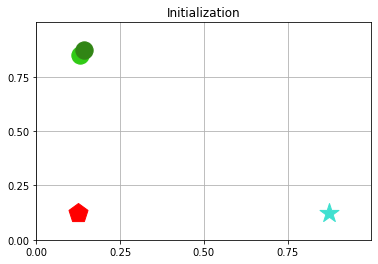

In [14]:
def plot_scatterplot(*args):

    # to print grid on map
    ax = plt.figure().gca()
    ax.set_xticks(np.arange(0, 1, 0.25))
    ax.set_yticks(np.arange(0, 1, 0.25))
    plt.grid()

    for i in Robotx._registry:
        # color gradient to better visualize the different robots within the map
        robot_color = hex(int("0x30ca15", 16) + int("0x00bb00", 16)*int(i.name[1])).replace("0x","#")
        plt.scatter(i.betax, i.betay, s = 300, marker = 'o', color = robot_color)
        
    plt.scatter(T.x, T.y, s = 400, marker = '*', color = 'turquoise')
    plt.scatter(O.x, O.y, s = 400, marker = 'p', color = 'red')

    plt.axis([0, 1, 0, 1])

    if args:
        plt.title(args[0])
        
    plt.show() 

plot_scatterplot("Initialization")

In [15]:
for r in Robotx._registry:
    if (r.delta < 0.5):
        print(f"{r.name} {r.delta:.2f} achtung!") # and start from this point to build the reshuffle section

R0 -0.04 achtung!
R1 -0.05 achtung!


In [16]:
# Grover planner -------------------------------------------------------------------------    

In [17]:
# takes as input strings with the binary encoding of cells and outputs the manhattan distance between them
def manhattan(start_cell, target_cell):
    start_cell_v, target_cell_v = [int(b) for b in start_cell], [int(b) for b in target_cell]
    return int(cityblock(start_cell_v, target_cell_v).item())

In [18]:
class GroverPlanner:

    def __init__(self, obstacles):
        self.obstacles = obstacles

    #
    # Utility functions
    #
    def XOR(self, qc, a, b, output):
        qc.cx(a, output)
        qc.cx(b, output)

    def encode_target(self, qc, target_cell, qubits):
        for idx, bit in enumerate(target_cell):
            bitn = int(bit)
            if not bitn:
                qc.x(qubits[idx])

    #
    # Grover diffuser
    #
    def diffuser(self, nqubits):
        diff = QuantumCircuit(nqubits)
        # Apply transformation |s> -> |00..0> (H-gates)
        for qubit in range(nqubits):
            diff.h(qubit)
        # Apply transformation |00..0> -> |11..1> (X-gates)
        for qubit in range(nqubits):
            diff.x(qubit)
        # Do multi-controlled-Z gate
        diff.h(nqubits - 1)
        diff.mct(list(range(nqubits - 1)), nqubits - 1)  # multi-controlled-toffoli
        diff.h(nqubits - 1)
        # Apply transformation |11..1> -> |00..0>
        for qubit in range(nqubits):
            diff.x(qubit)
        # Apply transformation |00..0> -> |s>
        for qubit in range(nqubits):
            diff.h(qubit)
        # We will return the diffuser as a gate
        U_s = diff.to_gate()
        U_s.name = "U$_\psi$"
        return U_s

    #
    # Grover oracle
    #
    # the oracle structure changes according to the number of movements required to get to the target
    #
    def oracle(self, num_of_M, target_cell, qc, pos_qubits, mov_qubits, c, output):

        if num_of_M == 1:
            # -- First M --
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])

            # -- Test operator --
            self.encode_target(qc, target_cell, [c[0], c[1]])
            qc.ccx(c[0], c[1], output)
            self.encode_target(qc, target_cell, [c[0], c[1]])

            # -- First M^-1 operator --
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])
        
        elif num_of_M == 2:

            # -- First M --
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])

            # -- Second M --
            self.XOR(qc, c[1], mov_qubits[1], c[2])
            qc.x(c[2])
            self.XOR(qc, c[0], mov_qubits[1], c[3])

            # -- Test operator --
            self.encode_target(qc, target_cell, [c[2], c[3]])
            qc.ccx(c[2], c[3], output)
            self.encode_target(qc, target_cell, [c[2], c[3]])

            # -- Second M^-1 operator --
            self.XOR(qc, c[0], mov_qubits[1], c[3])
            qc.x(c[2])
            self.XOR(qc, c[1], mov_qubits[1], c[2])

            # -- First M^-1 operator --
            self.XOR(qc, pos_qubits[0], mov_qubits[0], c[1])
            qc.x(c[0])
            self.XOR(qc, pos_qubits[1], mov_qubits[0], c[0])

    #
    # Path planning
    #
    def find_path(self, start_cell, target_cell):

        # number of M operators is equal to the Manhattan distance between start and target
        num_of_M = manhattan(start_cell, target_cell)

        # --- Initializations ---
        pos_qubits = QuantumRegister(2, name="r")
        mov_qubits = QuantumRegister(num_of_M, name="m")
        c = QuantumRegister(2*num_of_M, name="c")
        output = QuantumRegister(1, name="q")
        cbits = ClassicalRegister(2+num_of_M, name="cbits")

        qc = QuantumCircuit(pos_qubits, mov_qubits, c, output, cbits)

        qc.h(pos_qubits)

        # initialize mov_qubits in state |s>
        qc.h(mov_qubits)

        # initialize 'output0' in state |->
        qc.initialize([1, -1] / np.sqrt(2), output)

        # --- Oracle + Diffuser ---
        num_iterations = 1
        for _ in range(num_iterations):
            self.oracle(num_of_M, target_cell, qc, pos_qubits, mov_qubits, c, output)
            diff_qubits = [0, 1, 2] if num_of_M == 1 else [0, 1, 2, 3]
            qc.append(self.diffuser(2+num_of_M), diff_qubits)

        # --- Measurement ---
        qc.measure(pos_qubits, cbits[0:2])
        qc.measure(mov_qubits, cbits[2:(2+num_of_M)])

        # --- Simulation ---
        aer_sim = Aer.get_backend("aer_simulator")
        transpiled_qc = transpile(qc, aer_sim)
        result_counts = aer_sim.run(transpiled_qc).result().get_counts()

        return [k for k in result_counts.keys() if k[-2:] == start_cell[len(start_cell)::-1]]

groverPlanner = GroverPlanner([("10", "10")])


In [19]:
# test
groverPlanner.find_path(start_cell="01", target_cell="10")

['0010', '1110']

In [20]:
# Centroid handling -------------------------------------------------------------------------

In [21]:
# returns a dict so that:
#  - the keys are the coordinates of the centroids of a square dim_map x dim_map map of side length 1
#  - the values are in the form (micro_cell, macro_cell) of the centroids
def find_centroids(dim_map):

    unit_displacement = 1 / (dim_map*2)

    centroids_coords = []
    for i in range(dim_map,0,-1):
        row = []
        for j in range(dim_map): 
            row.append((j*unit_displacement*2 + unit_displacement, i*unit_displacement*2 - unit_displacement))
        centroids_coords.append(row)

    centroids_dict = {t: (f"{str(i%2)}{str(j%2)}", f"{0 if t[1] > 0.5 else 1}{0 if t[0] < 0.5 else 1}")
     for i,row in enumerate(centroids_coords) for j,t in enumerate(row)}
     
    return centroids_dict

centroids = find_centroids(4)

print("Centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in centroids.items()) + "}")

Centroids:
{ (0.125, 0.875): ('00', '00') 
  (0.375, 0.875): ('01', '00') 
  (0.625, 0.875): ('00', '01') 
  (0.875, 0.875): ('01', '01') 
  (0.125, 0.625): ('10', '00') 
  (0.375, 0.625): ('11', '00') 
  (0.625, 0.625): ('10', '01') 
  (0.875, 0.625): ('11', '01') 
  (0.125, 0.375): ('00', '10') 
  (0.375, 0.375): ('01', '10') 
  (0.625, 0.375): ('00', '11') 
  (0.875, 0.375): ('01', '11') 
  (0.125, 0.125): ('10', '10') 
  (0.375, 0.125): ('11', '10') 
  (0.625, 0.125): ('10', '11') 
  (0.875, 0.125): ('11', '11') }


In [22]:
# returns the centroid of the cell that a point of coordinates (x,y) is located in
def find_closest_centroid(centroids, x, y):
    centroids_coords = np.array(list(centroids.keys()))
    distances = np.linalg.norm(centroids_coords-np.array([x, y]), axis=1)
    return centroids[tuple(centroids_coords[np.argmin(distances)])]
    
for r in Robotx._registry:
    print(f"Closest centroid to {r.name}: {find_closest_centroid(centroids, r.betax, r.betay)}")

Closest centroid to R0: ('00', '00')
Closest centroid to R1: ('00', '00')


In [23]:
# Reshuffling ----------------------------------------------------------------------------

In [24]:
# returns a list with the micro and macro displacement after the movement
def eval_displacement(old_centroid, new_centroid):
    old_c_micro, old_c_macro = old_centroid
    new_c_micro, new_c_macro = new_centroid

    return [manhattan(old_c_micro, new_c_micro), manhattan(old_c_macro, new_c_macro)]

In [25]:
# computes the movements required to get to the position encoded in new_alphas, which has the form [new_alphax, new_alphay]
def compute_path_to_position(robot, new_alphas):

    # starting centroid
    old_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # assign new positions
    robot.alphax, robot.alphay = new_alphas
    robot.betax, robot.betay = 1 - robot.alphax, 1 - robot.alphay

    # new centroid
    new_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # displacement between the new and starting centroids
    displacement = eval_displacement(old_centroid, new_centroid)

    print(f"{robot.name} displacement from {old_centroid} to {new_centroid}: {displacement}")


    #
    # Planning the path according to the different possible displacement:
    #   - macro: the robot changes macro-cell but stays in the same micro-cell
    #   - micro: the robot changes micro-cell but stays in the same macro-cell
    #   - macro and micro: the robot changes both macro and micro cells
    #   - if the new position is in the same micro and macro cells nothing happens
    # 

    # --- Macro movement ---
    if displacement[0] == 0 and displacement[1] != 0:
        print(f"{robot.name}: macro")
        evaluated_path = groverPlanner.find_path(old_centroid[1], new_centroid[1])
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Micro movement ---
    elif displacement[0] != 0 and displacement[1] == 0:
        print(f"{robot.name}: micro")
        evaluated_path = groverPlanner.find_path(old_centroid[0], new_centroid[0])
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Macro and micro movement ---
    elif displacement[0] != 0 and displacement[1] != 0:
        print(f"{robot.name}: macro-micro")
        # macro path
        evaluated_path = groverPlanner.find_path(old_centroid[1], new_centroid[1])
        print(f"{robot.name} evaluated path (macro): {evaluated_path[0][:-2]}")
    
        # micro path
        evaluated_path = groverPlanner.find_path(old_centroid[0], new_centroid[0])
        print(f"{robot.name} evaluated path (micro): {evaluated_path[0][:-2]}")

    # if (i.betax - O.x <= 0.2 and i.betay - O.y <= 0.2):
    #     flag = True


In [26]:
result = all(i.delta < 0.8 for i in Robotx._registry)
print("Do all the robots have a reward lower than 0.8? : " + str(result))

# if True: reshuffle positions
# if False: do nothing

if result == True:
    for i in Robotx._registry:
        compute_path_to_position(i, [np.random.uniform(0,0.9), np.random.uniform(0,0.9)])
               

Do all the robots have a reward lower than 0.8? : True
R0 displacement from ('00', '00') to ('00', '10'): [0, 1]
R0: macro
R0 evaluated path: 0
R1 displacement from ('00', '00') to ('01', '01'): [1, 1]
R1: macro-micro
R1 evaluated path (macro): 1
R1 evaluated path (micro): 1


In [27]:
# recalculate the rewards
def recalculate_rewards():
    for i in Robotx._registry: # recalculate the rewards
        i.delta = reward(T, i.betax, i.betay)
        i.gamma = 1 - i.delta
        print(f"{i.name} {i.delta:.2f}")

In [28]:
recalculate_rewards()

R0 0.28
R1 0.31


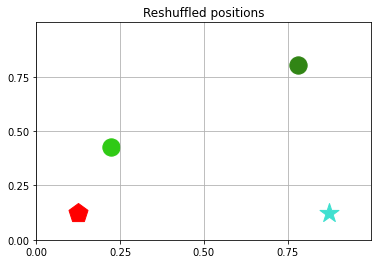

In [29]:
plot_scatterplot("Reshuffled positions")

In [30]:
# Quantum circuit construction ------------------------------------------------------------------

In [31]:
q = QuantumRegister(5, 'q') # qubits # changed to 9, formerly 15
m2 = ClassicalRegister(1, 'c1') # classical bits (separated is better)
m3 = ClassicalRegister(1, 'c2')
m4 = ClassicalRegister(1, 'c3')

qc3 = QuantumCircuit(q, m2, m3, m4) # to reach the target
qc4 = QuantumCircuit(q, m2, m3, m4) # to get back to the nest

In [32]:
# Which robot should enter the gate? -----------------------------------------------------------

In [33]:
def print_formatted_vector(*args):
    for vector in args:
        print("[" + "".join(f"{val:.2f} " for val in vector).strip() + "]")

In [34]:
# in case of ties on delta score, the max() function outputs the first maximum item it processes 
closest_robot = max(Robotx._registry, key=attrgetter('delta'))
print(f"Closest robot to the target: {closest_robot.name} {closest_robot.betax:.2f} {closest_robot.betay:.2f} {closest_robot.delta:.2f}")

# and then it enters the gate
vector0 = [closest_robot.alphax, closest_robot.betax]
vector1 = [closest_robot.alphay, closest_robot.betay]
vector3 = [closest_robot.gamma, closest_robot.delta]

normalized_v0 = vector0/np.linalg.norm(vector0)
normalized_v1 = vector1/np.linalg.norm(vector1)
normalized_v3 = vector3/np.linalg.norm(vector3)

print_formatted_vector(vector0, vector1, vector3)
print_formatted_vector(normalized_v0, normalized_v1, normalized_v3)

Closest robot to the target: R1 0.78 0.80 0.31
[0.22 0.78]
[0.20 0.80]
[0.69 0.31]
[0.27 0.96]
[0.24 0.97]
[0.91 0.42]


In [35]:
# Setting up |q_0> ------------------------------------------------------------------------------

In [36]:
# direct initialization with amplitudes vector
qc3.initialize(normalized_v0, q[0])
qc3.initialize(normalized_v1, q[1])
qc3.initialize(normalized_v3, q[2])

In [37]:
# this is the core code, and it is unchanged across time

qc3.barrier(q)
qc3.ccx(q[0],q[1],q[3])
qc3.ccx(q[0],q[1],q[4])

qc3.reset(q[3])
qc3.reset(q[4])

qc3.ccx(q[0],q[2],q[3]) 
qc3.ccx(q[1],q[2],q[4])

qc3.x(q[2])

qc3.ch(q[2],q[3])
qc3.ch(q[2],q[4])

qc3.x(q[2])

qc3.barrier(q)

# perform measurements and store them in classical bits

qc3.measure(q[2],m2[0])
qc3.measure(q[3],m3[0])
qc3.measure(q[4],m4[0])

# visualization of the ciruit

# qc3.draw(fold=-1, output="mpl")
# plt.show();

print(qc3)

      ┌────────────────────────────┐ ░                                         »
 q_0: ┤ Initialize(0.2694,0.96303) ├─░───■────■─────────■──────────────────────»
      ├───────────────────────────┬┘ ░   │    │         │                      »
 q_1: ┤ Initialize(0.237,0.97151) ├──░───■────■─────────┼────■─────────────────»
      ├───────────────────────────┴┐ ░   │    │         │    │  ┌───┐          »
 q_2: ┤ Initialize(0.90877,0.4173) ├─░───┼────┼─────────■────■──┤ X ├──■────■──»
      └────────────────────────────┘ ░ ┌─┴─┐  │       ┌─┴─┐  │  └───┘┌─┴─┐  │  »
 q_3: ───────────────────────────────░─┤ X ├──┼───|0>─┤ X ├──┼───────┤ H ├──┼──»
                                     ░ └───┘┌─┴─┐     └───┘┌─┴─┐     └───┘┌─┴─┐»
 q_4: ───────────────────────────────░──────┤ X ├─|0>──────┤ X ├──────────┤ H ├»
                                     ░      └───┘          └───┘          └───┘»
c1: 1/═════════════════════════════════════════════════════════════════════════»
                            

counts:  {'1 1 1': 141, '0 1 0': 222, '1 0 0': 196, '0 0 0': 218, '1 1 0': 226, '1 0 1': 9, '0 1 1': 12}


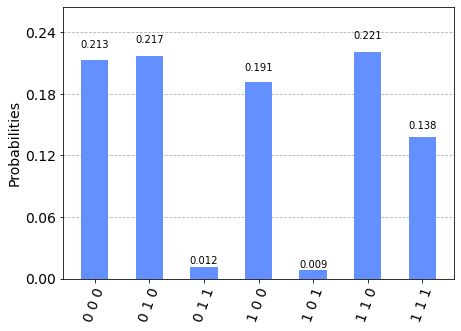

In [38]:
# --- Simulation ---
aer_sim = Aer.get_backend("aer_simulator")
transpiled_qc = transpile(qc3, aer_sim)
result = aer_sim.run(transpiled_qc).result()

counts = result.get_counts()
print("counts: ", counts)

plot_histogram(result.get_counts())

In [39]:
# calculate weighted outcome on the most probables outcomes of the circuit
def eval_outcome(most_prob_dict, n_outcome):
    mapped_weights = list(map(lambda res: int(res[n_outcome*2])*most_prob_dict[res], most_prob_dict))
    return sum(mapped_weights)/sum(most_prob_dict.values())

In [40]:
num_most_prob_states = 4

# extract the most probable states and then evaluate the outcome
most_prob_dict = dict(heapq.nlargest(num_most_prob_states, counts.items(), key=itemgetter(1)))
print(f"{num_most_prob_states} most probable states: {most_prob_dict}")

outcome0, outcome1 = eval_outcome(most_prob_dict, 0), eval_outcome(most_prob_dict, 1)

print(f"outcome0: {outcome0:.2f}\noutcome1: {outcome1:.2f}")

4 most probable states: {'1 1 0': 226, '0 1 0': 222, '0 0 0': 218, '1 0 0': 196}
outcome0: 0.49
outcome1: 0.52


In [41]:
# Setting new positions after the gate ---------------------------------------------------------------

In [42]:
for i in Robotx._registry:
    print(f"{i.name} {i.betax:.2f} {i.betay:.2f}")
    if (i.delta != closest_robot.delta or all(i.delta == j.delta for j in Robotx._registry)): # excluding the robot that entered the gate
        # CHANGE: but taking into account the case where all robots have the same reward!!!
        # for z
        #i.betaz = outcome0
        # the lower this value, the closer the robot to the 0, the higher alphaz
        #i.alphaz = round(1 - i.betaz, 3)

        compute_path_to_position(i, [1-outcome1, 1-outcome0])

        # # for y
        # i.betay = outcome0 # changed this
        # i.alphay = 1 - i.betay
        
        # # for x
        # i.betax = outcome1 # changed this
        # i.alphax = 1 - i.betax

        

R0 0.22 0.43
R0 displacement from ('00', '10') to ('00', '11'): [0, 1]
R0: macro
R0 evaluated path: 0
R1 0.78 0.80


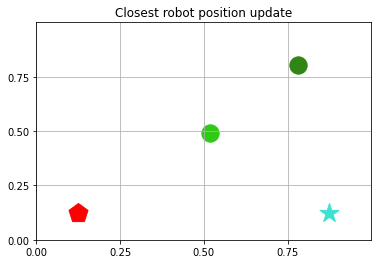

In [43]:
plot_scatterplot("Closest robot position update")

In [44]:
# former rewards 
for i in  Robotx._registry:
    print(f"before the gate: {i.name} {i.delta:.2f}")

before the gate: R0 0.28
before the gate: R1 0.31


In [45]:
# new rewards
print("Rewards after the gate: ")
recalculate_rewards()

Rewards after the gate: 
R0 0.49
R1 0.31


In [46]:
# Reach the most successful robot -------------------------------------------------------

In [47]:
# get the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_): 
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.01), max_attr_.alphay + np.random.uniform(0,0.01)])
                   

max_attr_.delta: 0.49
Most successful robot: R0 0.52 0.49 0.49
R1 displacement from ('01', '01') to ('00', '11'): [1, 1]
R1: macro-micro
R1 evaluated path (macro): 1
R1 evaluated path (micro): 0


In [48]:
recalculate_rewards()

R0 0.49
R1 0.49


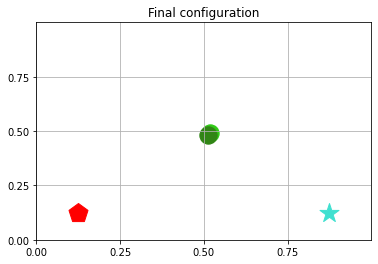

In [49]:
plot_scatterplot("Final configuration")